In [ ]:
library(tidyverse)
library(mfbvar)
library(imputeTS)
library(Rmisc)

In [2]:
# helper function, generate lagged datasets for testing on vintages
gen_lagged_data <- function (metadata, data, last_date, lag) {
  # only go up to the last date
  lagged_data <- data %>% 
    dplyr::filter(date <= last_date)
  
  for (col in colnames(lagged_data)[2:length(colnames(lagged_data))]) {
    pub_lag <- metadata %>% 
      dplyr::filter(series == col) %>% 
      select(months_lag) %>% 
      pull()
    
    # go back as far as needed for the pub_lag of the variable, then + the lag (so -2 for 2 months back)
    condition <- (nrow(lagged_data) - pub_lag + lag)
    # only input NA if the lag is less than the latest row in the data
    if (condition <= nrow(lagged_data)) {
      lagged_data[condition:nrow(lagged_data), col] <- NA
    } 
  }
  lagged_data <- lagged_data %>% 
    dplyr::filter(!is.na(date))
  return (lagged_data)
}

# Data set up

In [ ]:
# full data read
metadata <- read_csv("../data/meta_data.csv")
data <- read_csv("../data/data_tf.csv") %>%
  arrange(date)

target_variable <- "gdpc1"

# which lags to assess
lags <- -2:2

# dates for 3 testing periods
train_start_date <- "1947-01-01"
train_end_date <- "2004-12-01"
test_start_date <- "2005-03-01"
test_end_date <- "2010-12-01"

# train and test datasets
train <- data %>%
    filter(date >= train_start_date, date <= train_end_date) %>%
    # the nowcastDFM library only works with dataframe, may get errors in estimation if you use tibbles
    data.frame()
test <- data %>%
    filter(date >= train_start_date, date <= test_end_date) %>% # let test set data begin from training begin, data lag/time series for test sets can go back into the training data
    data.frame()

# replace any infinites with NA
for (col in colnames(train)) {
    if (sum(is.infinite(train[,col])) > 0) {
      train[is.infinite(train[,col]), col] <- NA 
    }
}

for (col in colnames(test)) {
    if (sum(is.infinite(test[,col])) > 0) {
      test[is.infinite(test[,col]), col] <- NA 
    }
}

Data should be a dataframe of seasonally adjusted growth rates with months in rows and quarterly variables in the last month of the quarter, with `np.nan`s for interquarter months.

In [4]:
tail(data)

date,payems,gdpc1,cpiaucsl,unrate,houst,indpro,dspic96,cpilfesl,pcepilfe,pcepi,permit,ulcnfb,a261rx1q020sbea
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2021-08-01,0.003285871,NA,0.002743650,-0.03703704,0.007042254,-0.001631945,-0.001061726,0.001017724,0.003134983,0.003824009,0.05582822,NA,NA
2021-09-01,0.002569910,0.005709481,0.004124361,-0.09615385,-0.014621742,-0.009759164,-0.016184669,0.002430747,0.002405292,0.003465474,-0.07844277,0.02311136,0.01429745
2021-10-01,0.004382672,NA,0.009433205,-0.02127660,0.001290323,0.012332928,-0.001649621,0.005992493,0.004427284,0.006487107,0.04224464,NA,NA
2021-11-01,0.001676734,NA,0.007791157,-0.08695652,0.081185567,0.007374793,-0.001950417,0.005346208,0.004803122,0.006266496,0.03871748,NA,NA
2021-12-01,0.001337797,0.016790944,0.004704532,-0.07142857,0.014302741,-0.001023560,-0.002285343,0.005501393,0.004981080,0.004475995,0.09784508,NA,NA
2022-01-01,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


# Training the model
Because of how Bayesian VAR models are estimated, similar to ARMA models, there is no model training per se, the model is fitted and n-step ahead forecasts are generated at each data vintage in the testing set. This gives the model a bit more training information than the other methodologies, but there is no workaround I am aware of to to generate estimates on the test set with information exclusively from the training set.

# Testing the model on artificial data vintages

In [5]:
# dates in the test set
dates <- seq(as.Date(test_start_date), as.Date(test_end_date), by="month") %>% 
      .[(substr(., 6, 7) %in% c("03", "06", "09", "12"))]

In [6]:
# dataframe for predictions
pred_dict <- data.frame(date = dates)
for (lag in lags) {
  pred_dict[,as.character(lag)] <- NA
}
# looping through test dates
for (date in as.character(dates)) {
  for (lag in lags) {
    lagged_data <- gen_lagged_data(metadata, test, date, lag) %>% 
      data.frame
    # make sure actual value not in there
    lagged_data[lagged_data$date == date, target_variable] <- NA
      
    # preserving NA structure at end, but filling earlier rows with mean to be able to estimate
    lagged_data[1:(round(nrow(lagged_data) * 0.9, 0)),] <- na_mean(lagged_data[1:(round(nrow(lagged_data) * 0.9, 0)),])
    lagged_data <- lagged_data[rowSums(is.na(lagged_data)) != ncol(lagged_data)-1, ] # drop end rows with only nas
    
    # converting to data format for mfbvar
    mf_test <- list()
    for (col in colnames(train)[2:length(colnames(train))]) {
        # get data frequency
        freq <- metadata %>% 
          filter(series == !!col) %>% 
          select(freq) %>% 
          pull()
        if (freq == "q") {
          freq <- 4
          tmp_series <- lagged_data %>% 
            filter(substr(date, 6, 7) %in% c("03", "06", "09", "12")) %>% 
            select(!!col) %>%
            slice(2:n()) %>% # first row is all NAs, so drop
            pull()
        } else {
          freq <- 12
          tmp_series <- lagged_data %>%
            select(!!col) %>% 
            slice(2:n()) %>%
            pull()
        }
        # convert data to correct time series format, set start date to correct start date of your data
        tmp_ts <- ts(tmp_series, start = c(1947,2), frequency = freq)
        mf_test[[col]] <- tmp_ts
    }
    
    # reorder the list to have quarterly variables, `ulcnfb` and `a261rx1q020sbea`, come last. Necessary for mfbvar library
    mf_test <- list(
      payems=mf_test$payems,
      cpiaucsl=mf_test$cpiaucsl,
      unrate=mf_test$unrate,
      houst=mf_test$houst,
      indpro=mf_test$indpro,
      dspic96=mf_test$dspic96,
      cpilfesl=mf_test$cpilfesl,
      pcepilfe=mf_test$pcepilfe,
      pcepi=mf_test$pcepi,
      permit=mf_test$permit,
      ulcnfb=mf_test$ulcnfb,
      a261rx1q020sbea=mf_test$a261rx1q020sbea,
      gdpc1=mf_test$gdpc1
    )
      
    # actual bayesian var estimation
    prior <- set_prior(Y = mf_test, n_lags = 4, n_reps = 100)
    c_interval <- t(sapply(mf_test, CI, ci=0.95))
    prior_intervals <- c_interval[,c("upper","lower")]
    moments <- interval_to_moments(prior_intervals)
    prior <- update_prior(prior, d="intercept", prior_psi_mean = moments$prior_psi_mean,  prior_psi_Omega = moments$prior_psi_Omega)
    prior <- update_prior(prior, n_fcst = 12)

    model <- estimate_mfbvar(prior, prior = "minn", variance = "iw")

    prediction <- predict(model, pred_bands = NULL) %>% 
        filter(variable == target_variable, fcst_date == date) %>% 
        select(fcst) %>% 
        pull() %>% 
        mean()
    
    pred_dict[pred_dict$date == date, as.character(lag)] <- prediction
  }
}

# Assess and visualize model performance

In [7]:
actuals <- test %>%
    filter(date >= test_start_date) %>%
    select(!!target_variable) %>%
    filter(!is.na(!!sym(target_variable))) %>%
    pull()

In [8]:
performance <- data.frame(Vintage = numeric(), RMSE = numeric())
for (lag in lags) {
    tmp = data.frame(
        Vintage = lag,
        RMSE = sqrt(mean((actuals - pred_dict[,as.character(lag)])**2))
    )
    performance = rbind(performance, tmp)
}
round(performance, 4)

Vintage,RMSE
<dbl>,<dbl>
-2,0.0050
-1,0.0048
0,0.0045
1,0.0040
2,0.0043


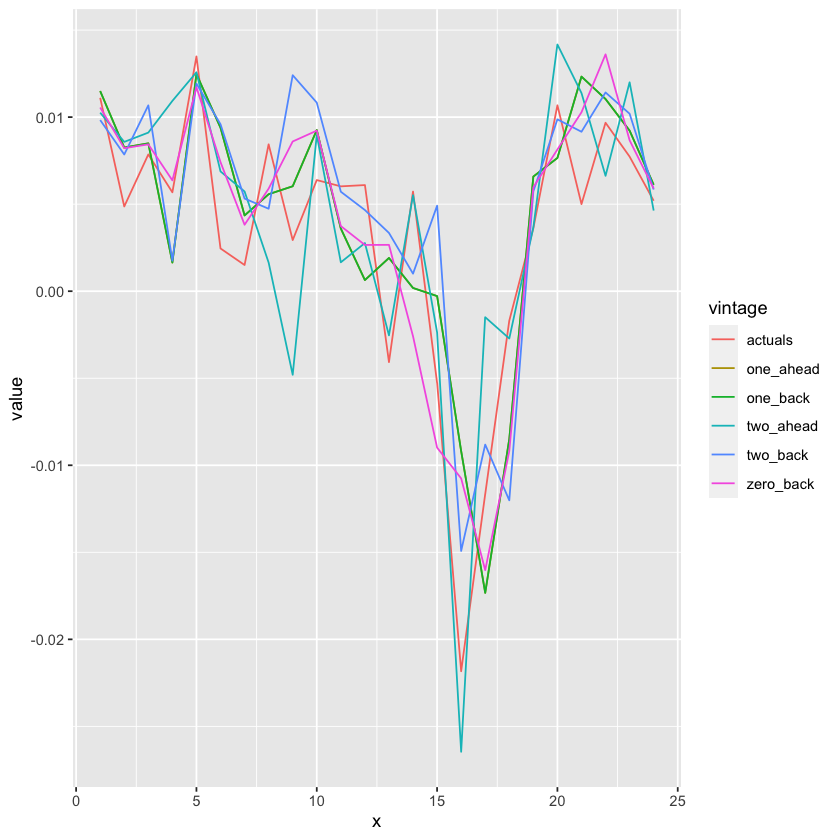

In [11]:
# plot of predictions vs actuals
p <- tibble(
    actuals = actuals,
    two_back = pred_dict[, "-2"], 
    one_back = pred_dict[, "-1"], 
    zero_back = pred_dict[, "0"],
    one_ahead = pred_dict[, "-1"],
    two_ahead = pred_dict[, "2"]
) %>%
    dplyr::mutate(x = 1:n()) %>%
    gather(vintage, value, -x) %>%
    ggplot() + 
    aes(x=x, y=value, color=vintage) + 
    geom_line()
p

# Final model usage / getting predictions on new data
Say model selection is finished and the model is to now be used, i.e. used to get predictions on new data.

In [14]:
# the test data ends 2010-12-01, let's say we wanted to predict 2011-03-01
new_data = test

# preserving NA structure at end, but filling earlier rows with mean to be able to estimate
new_data[1:(round(nrow(new_data) * 0.9, 0)),] <- na_mean(new_data[1:(round(nrow(new_data) * 0.9, 0)),])
new_data <- lagged_data[rowSums(is.na(new_data)) != ncol(new_data)-1, ] # drop end rows with only nas

# converting to data format for mfbvar
mf_test <- list()
for (col in colnames(train)[2:length(colnames(train))]) {
    # get data frequency
    freq <- metadata %>% 
      filter(series == !!col) %>% 
      select(freq) %>% 
      pull()
    if (freq == "q") {
      freq <- 4
      tmp_series <- new_data %>% 
        filter(substr(date, 6, 7) %in% c("03", "06", "09", "12")) %>% 
        select(!!col) %>%
        slice(2:n()) %>% # first row is all NAs, so drop
        pull()
    } else {
      freq <- 12
      tmp_series <- new_data %>%
        select(!!col) %>% 
        slice(2:n()) %>%
        pull()
    }
    # convert data to correct time series format, set start date to correct start date of your data
    tmp_ts <- ts(tmp_series, start = c(1947,2), frequency = freq)
    mf_test[[col]] <- tmp_ts
}

# reorder the list to have quarterly variables, `ulcnfb` and `a261rx1q020sbea`, come last. Necessary for mfbvar library
mf_test <- list(
  payems=mf_test$payems,
  cpiaucsl=mf_test$cpiaucsl,
  unrate=mf_test$unrate,
  houst=mf_test$houst,
  indpro=mf_test$indpro,
  dspic96=mf_test$dspic96,
  cpilfesl=mf_test$cpilfesl,
  pcepilfe=mf_test$pcepilfe,
  pcepi=mf_test$pcepi,
  permit=mf_test$permit,
  ulcnfb=mf_test$ulcnfb,
  a261rx1q020sbea=mf_test$a261rx1q020sbea,
  gdpc1=mf_test$gdpc1
)

In [16]:
# actual bayesian var estimation
prior <- set_prior(Y = mf_test, n_lags = 4, n_reps = 100)
c_interval <- t(sapply(mf_test, CI, ci=0.95))
prior_intervals <- c_interval[,c("upper","lower")]
moments <- interval_to_moments(prior_intervals)
prior <- update_prior(prior, d="intercept", prior_psi_mean = moments$prior_psi_mean,  prior_psi_Omega = moments$prior_psi_Omega)
prior <- update_prior(prior, n_fcst = 12)

model <- estimate_mfbvar(prior, prior = "minn", variance = "iw")

predict(model, pred_bands = NULL) %>% 
    filter(variable == target_variable, fcst_date == "2011-03-01") %>% 
    select(fcst) %>% 
    pull() %>% 
    mean()

[1] 0.01116272